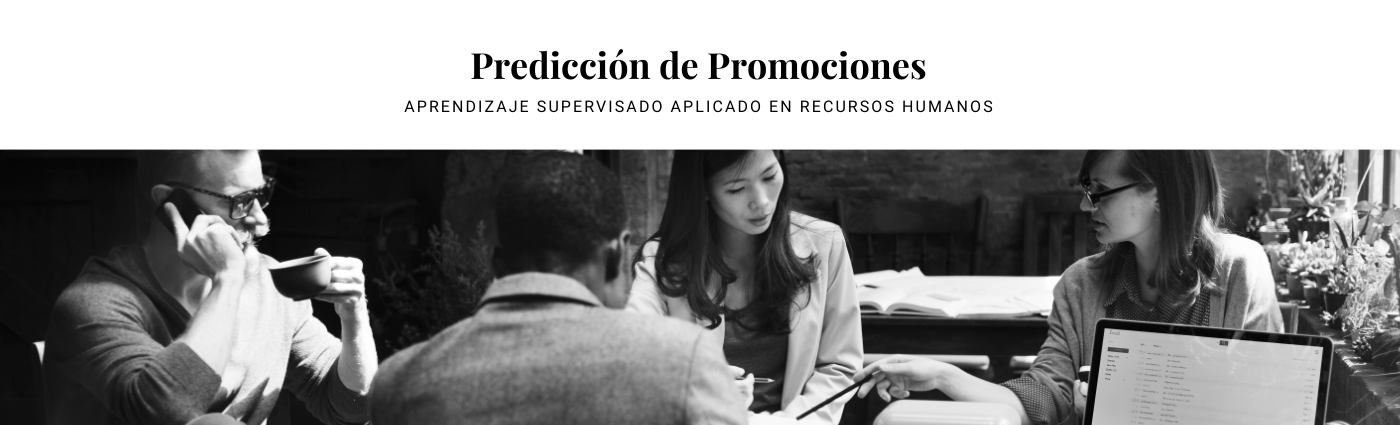

Nuestro cliente es una larga empresa multinacional compuesta por 9 sucursales. Uno de los problemas que enfrentan al ser una empresa tan grande, es de identificar a las mejores personas para promoverlas y prepararlas con tiempo.

El actual proceso que utilizan les lleva demasiado tiempo en evaluarlos y esto provoca retrasos en la transición a sus nuevos roles. Por esta razón, ellos necesitan poder identificar con antelación a los posibles candidatos que serán promovidos antes de terminar el lento proceso de evaluación.

Para intentar solucionarlo, en este projecto vamos a hacer un recorrido completo: desde la visualización y análisis de las variables relacionadas con nuestra variable objetivo a predecir, pasando por la limpieza de datos y modelado de algoritmos de aprendizaje supervisado para clasificación, ajuste de hiperparámetros, y finalizando con predicciones sobre nueva información.

La base de datos fue obtenida de [Kaggle]("http://www.kaggle.com") y proviene de una competencia real.
Tenemos un dataset (train) con información sociodemográfica y de desempeños previos sobre empleados, y otro dataset(test) sobre el cuál debemos predecir los empleadores que serán promovidos.

Información disponible:
1. "employee_id": numero identificador de cada empleado
2. "department": área de trabajo donde se desempeña el empleado
3. "region": de qué región proviene (anonimizado)
4. "education": mayor nivel de educación alcanzado
5. "gender": género
6. "recruitment_channel": canal por dónde fue reclutado
7. "no_of_trainings": cantidad de capacitaciones completadas previas
8. "age": edad
9. "previous_year_rating": calificación (del 1 al 5) obtenida en el año anterior
10. "length_of_service": años de antigüedad
11. "KPIs_met >80%": si ha completado más del 80% de los KPI (Key Performance Indicators)
12. "awards_won?": premios que ha ganado en el año anterior
13. "avg_training_score": promedio de puntajes obtenidos de las evaluaciones de sus capacitaciones actuales
14. "is_promoted": si fue promovido (1) o no (0)

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
sns.set_palette("pastel")
import plotly.express as px
from plotly.subplots import make_subplots
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("C:/Users/lauta/Desktop/train.csv")
test_full = pd.read_csv("C:/Users/lauta/Desktop/test.csv")
df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [2]:
print("Cantidad de observaciones totales: " +str(len(df)))

Cantidad de observaciones totales: 54808


Podemos ver que hay algunos valores Nulos para las variables de educación y rating del año anterior. En estas situaciones, tenemos dos caminos: eliminar las filas enteras que contienen datos inválidos, o imputarles algún valor. En este caso en particular, ya que solo vamos a utilizar estos datos para entrenar nuestro algoritmo, vamos a proceder a eliminar las filas.

In [3]:
df = df.dropna()
print("Cantidad de observaciones sin valores nulos: " +str(len(df)))

Cantidad de observaciones sin valores nulos: 48660


Al observar cuidadosamente, vemos que una variable numérica es de tipo "float64", lo que nos puede dificultar hacer algunas operaciones en el futuro, así que vamos a cambiar su formato a "integer".

In [4]:
df['previous_year_rating'] = df['previous_year_rating'].astype(np.int64)

# Análisis de Datos y Visualización

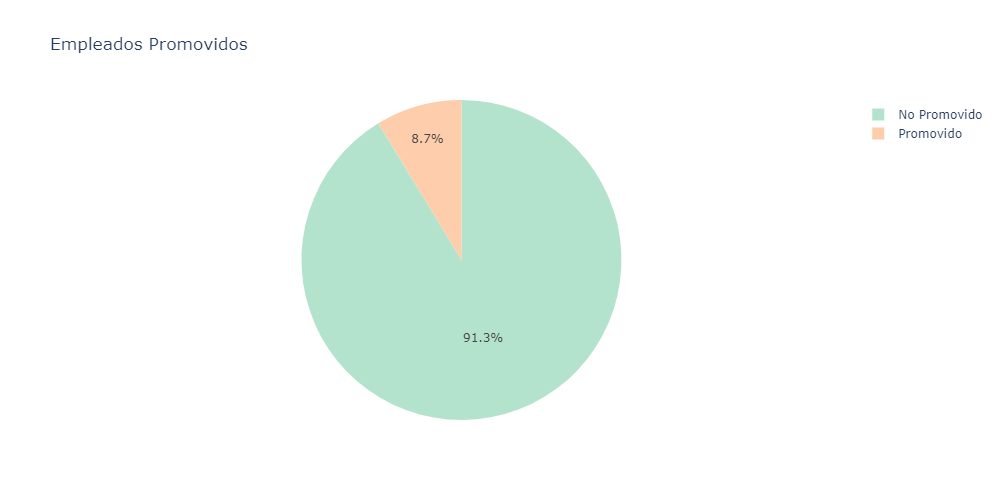

In [5]:
promo = pd.DataFrame(df.is_promoted.value_counts())
promo.columns = ["Promoted"]
promo["Valores"] = promo.index
promo["Valores"] = promo["Valores"].map({0:"No Promovido", 1:"Promovido"})
fig = px.pie(promo, values= "Promoted", names = "Valores", title = "Empleados Promovidos", color_discrete_sequence=px.colors.qualitative.Pastel2)
fig.update_layout(
    autosize=False,
    width=1000,
    height=500)
pie = fig.to_image(format= "png")
Image(pie)

Naturalmente, la variable está muy desbalanceada: tenemos pocos casos de promociones comparados con los empleados que no son promovidos, como es de esperar en cualquier organización.

### Departamentos

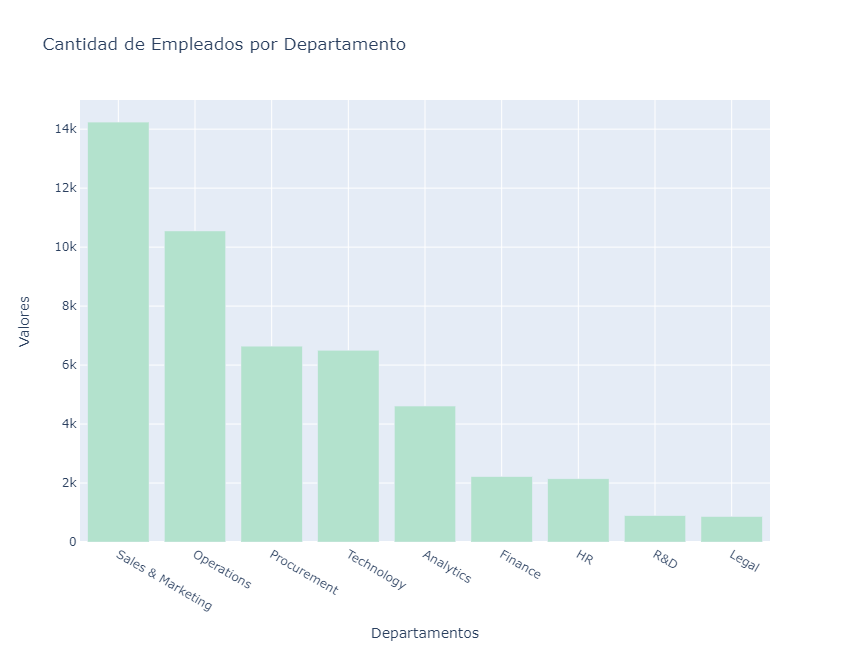

In [6]:
depart = pd.DataFrame(df.department.value_counts())
depart.columns = ["Valores"]
depart["Departamentos"] = depart.index
fig = px.bar(depart, x = "Departamentos", y= "Valores", title = "Cantidad de Empleados por Departamento", color_discrete_sequence=px.colors.qualitative.Pastel2)
fig.update_layout(
    autosize=False,
    width=850,
    height=650)
bar = fig.to_image(format= "png")
Image(bar)

Porcentaje de Empleados Promovidos en Departamento Sales & Marketing: 8.04%
Porcentaje de Empleados Promovidos en Departamento Operations: 10.23%
Porcentaje de Empleados Promovidos en Departamento Procurement: 11.59%
Porcentaje de Empleados Promovidos en Departamento Technology: 11.21%
Porcentaje de Empleados Promovidos en Departamento Analytics: 10.68%
Porcentaje de Empleados Promovidos en Departamento Finance: 8.93%
Porcentaje de Empleados Promovidos en Departamento HR: 5.99%
Porcentaje de Empleados Promovidos en Departamento R&D: 6.95%
Porcentaje de Empleados Promovidos en Departamento Legal: 5.09%


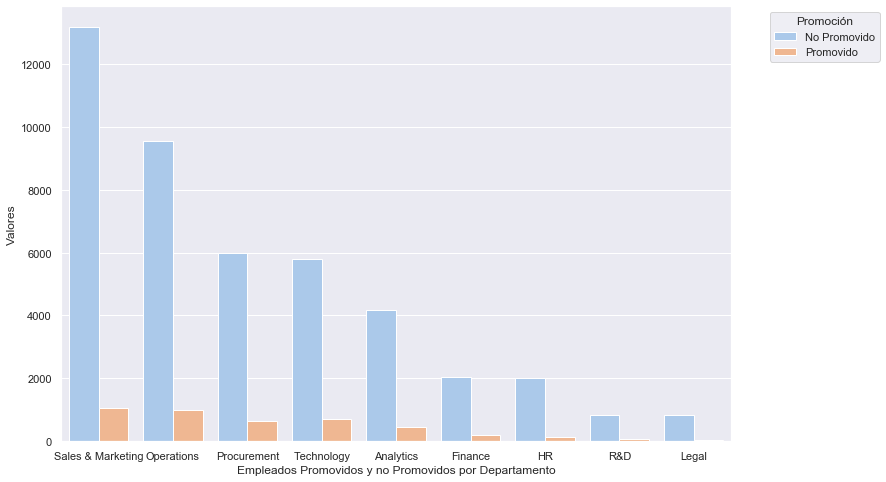

In [7]:
depart = pd.DataFrame(df.groupby("is_promoted").department.value_counts().reset_index(name='Valores'))
for i in range(0,9):
    value = round(depart[depart["is_promoted"] == 1].iloc[i,2] / depart[depart["is_promoted"] == 0].iloc[i,2] * 100, 2)
    nombre = depart.iloc[i,1]
    print(f"Porcentaje de Empleados Promovidos en Departamento "+ str(nombre) + ": " + str(value) + "%")
depart["is_promoted"] = depart["is_promoted"].map({0:"No Promovido", 1:"Promovido"})

plt.figure(figsize=(12, 8))
sns.barplot(x='department', y='Valores', data=depart, hue='is_promoted')
plt.legend(title='Promoción', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Empleados Promovidos y no Promovidos por Departamento')
plt.show()

Observamos que las promociones son relativas a la cantidad de empleados de cada departamento. A simple vista no hay ningún departamento que llame la atención. Quizás promover un número equitativo de empleados por departamento incluso sea una política de la empresa. Conocer esta informacións nos sería útil para nuestra tarea.

### Región 

Los empleados de la organización provienen de 34 regiones diferentes.


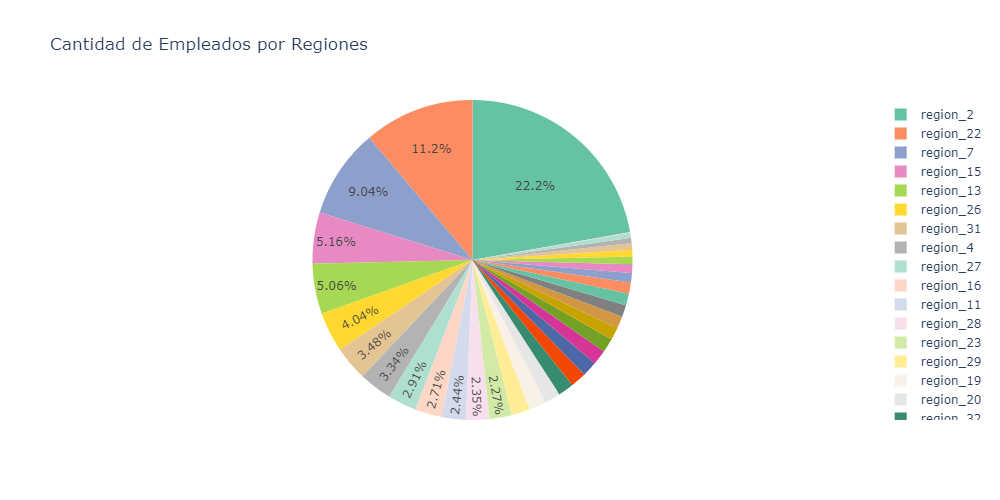

In [8]:
region = pd.DataFrame(df.region.value_counts())
region.columns = ["Regiones"]
region["Valores"] = region.index
fig = px.pie(region, values= "Regiones", names = "Valores", title = "Cantidad de Empleados por Regiones",color_discrete_sequence=px.colors.qualitative.Set2)
fig.update_traces(textposition='inside')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig.update_layout(
    autosize=False,
    width=1000,
    height=500)
pie = fig.to_image(format= "png")
print("Los empleados de la organización provienen de " + str(df.region.nunique()) + " regiones diferentes.")
Image(pie)


### Educación

Porcentaje de Empleados Promovidos en Departamento Bachelor's: 8.91%
Porcentaje de Empleados Promovidos en Departamento Master's & above: 10.97%
Porcentaje de Empleados Promovidos en Departamento Below Secondary: 8.53%


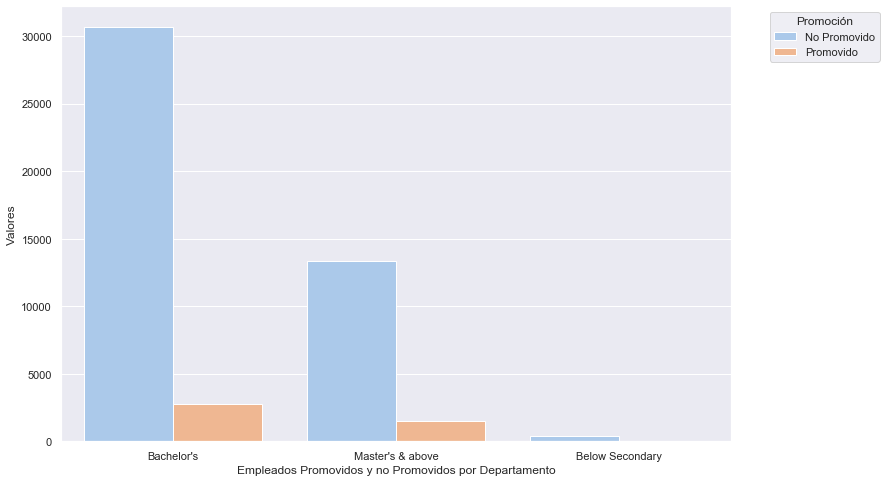

In [9]:
educ = pd.DataFrame(df.groupby("is_promoted").education.value_counts().reset_index(name='Valores'))
for i in range(0,3):
    value = round(educ[educ["is_promoted"] == 1].iloc[i,2] / educ[educ["is_promoted"] == 0].iloc[i,2] * 100, 2)
    nombre = educ.iloc[i,1]
    print(f"Porcentaje de Empleados Promovidos en Departamento "+ str(nombre) + ": " + str(value) + "%")

educ["is_promoted"] = educ["is_promoted"].map({0:"No Promovido", 1:"Promovido"})

plt.figure(figsize=(12, 8))
sns.barplot(x='education', y='Valores', data=educ, hue='is_promoted')
plt.legend(title='Promoción', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Empleados Promovidos y no Promovidos por Departamento')
plt.show()

Se puede observar que la cantidad de empleados promovidos en relación a la educación alcanzada es relativa a la cantidad absoluta de los empleados en cada una de estas categorías.

### Género

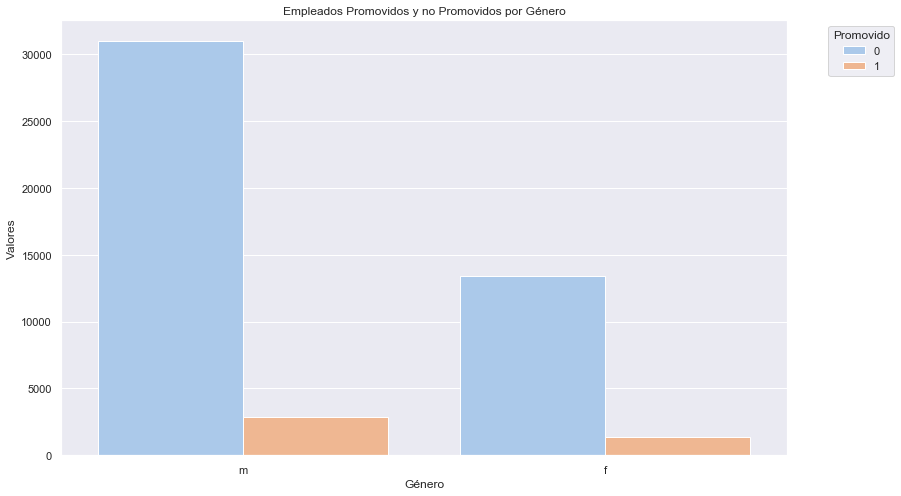

In [10]:
genero = pd.DataFrame(df.groupby("is_promoted").gender.value_counts().reset_index(name='Valores'))

plt.figure(figsize=(13, 8))
sns.barplot(x='gender', y='Valores', data=genero, hue='is_promoted')
plt.title("Empleados Promovidos y no Promovidos por Género")
plt.legend(title='Promovido', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Género')
plt.show()

### Canal de Reclutamiento

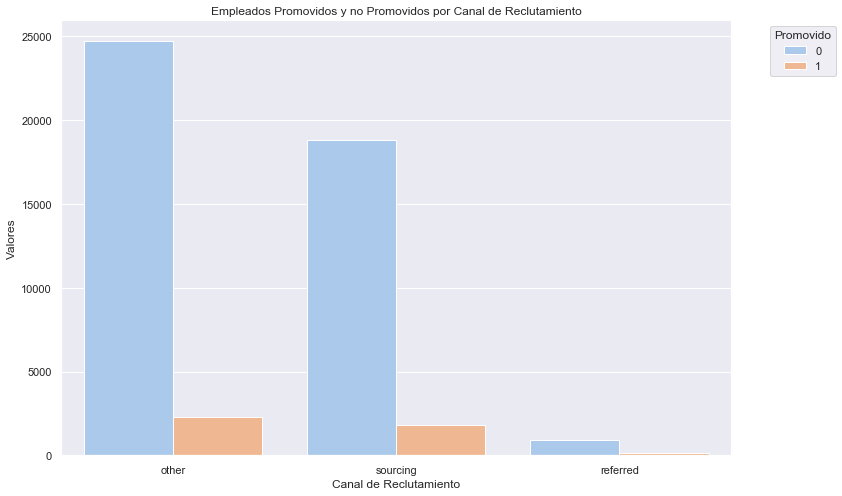

In [11]:
canal = pd.DataFrame(df.groupby("is_promoted").recruitment_channel.value_counts().reset_index(name='Valores'))

plt.figure(figsize=(12, 8))
sns.barplot(x='recruitment_channel', y='Valores', data=canal, hue='is_promoted')
plt.title("Empleados Promovidos y no Promovidos por Canal de Reclutamiento")
plt.legend(title='Promovido', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Canal de Reclutamiento')
plt.show()

### Cantidad de Entrenamientos

Text(0.5, 0, 'Cantidad de Capacitaciones')

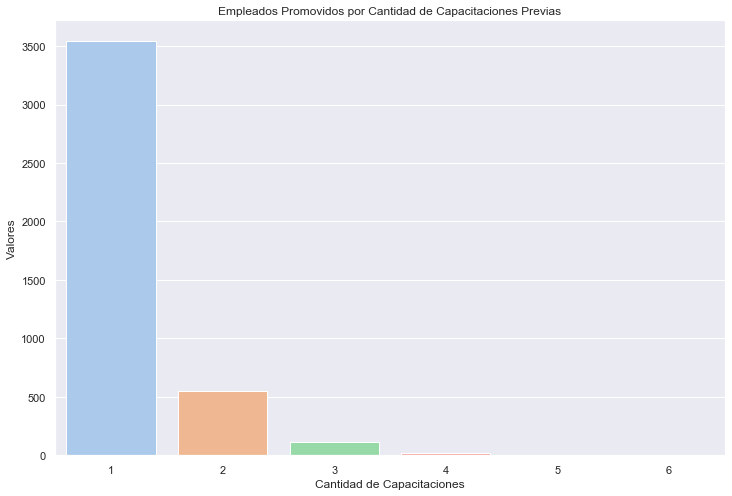

In [12]:
entrenamientos = pd.DataFrame(df.groupby("is_promoted").no_of_trainings.value_counts().reset_index(name='Valores'))
promo_entrenamientos = entrenamientos[entrenamientos["is_promoted"]==1]
plt.figure(figsize=(12, 8))
sns.barplot(data=promo_entrenamientos, x="no_of_trainings", y="Valores")
plt.title("Empleados Promovidos por Cantidad de Capacitaciones Previas")
plt.xlabel('Cantidad de Capacitaciones')

Observamos que la mayoría de los empleados promovidos solo ha tenido 1 capacitación. El mayor número de capacitaciones ha sido 6 para los empleados promovidos. La cantidad de capacitaciones no parece ser un determinante muy fuerte para la promoción en esta organización.

## Variables Numéricas

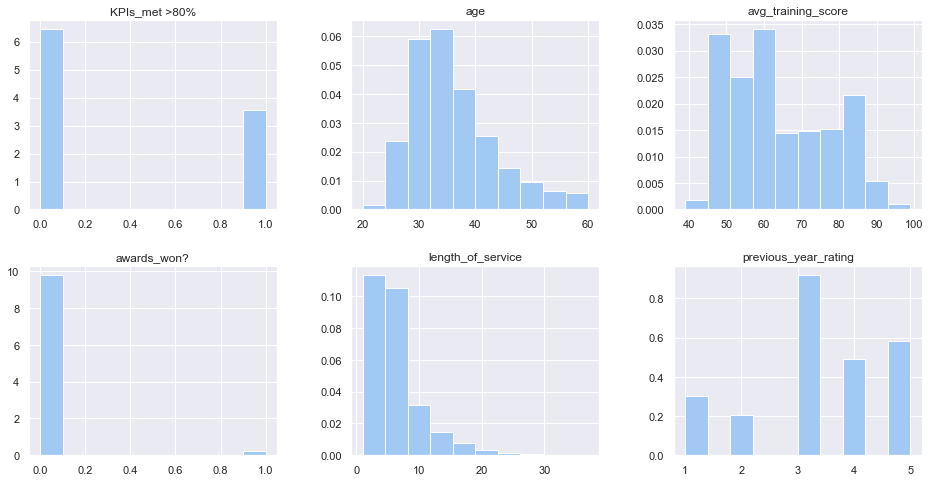

In [13]:
numericas = ["age", "previous_year_rating", "length_of_service","KPIs_met >80%","awards_won?","avg_training_score"]
df[numericas].hist(figsize=(16,8),layout=(2,3), density=True)
plt.show()

### Edad

La media de edad de los empleados es 36.0
Le mediana de edad de los empleados es 34.0


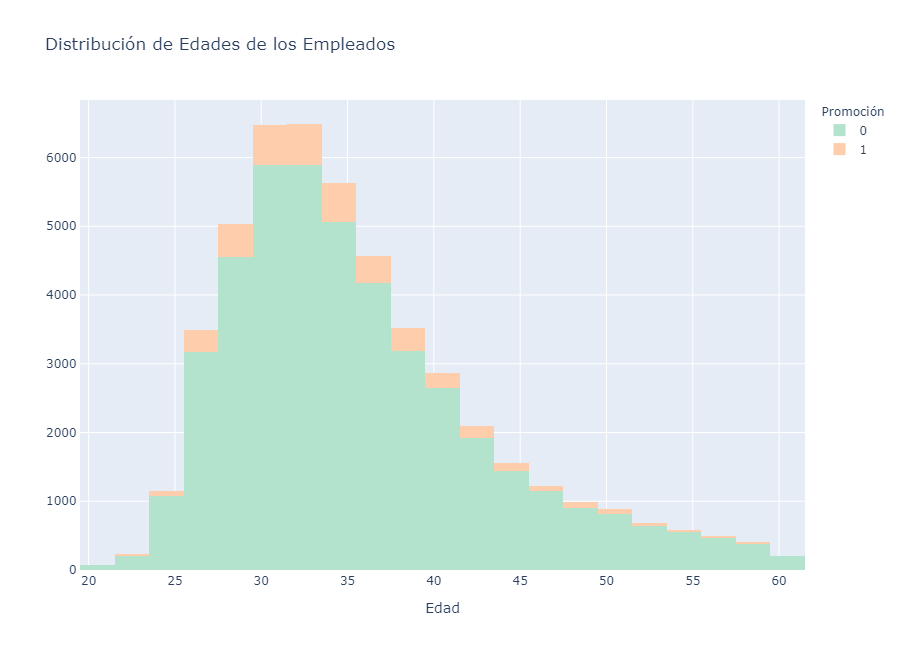

In [14]:
fig = px.histogram(df, x="age", title = "Distribución de Edades de los Empleados", color = "is_promoted", labels= {"age":"Edad","is_promoted": "Promoción"},nbins=35, color_discrete_sequence=px.colors.qualitative.Pastel2)
fig.update_layout(yaxis_title=" ")
fig.update_layout(
    autosize=False,
    width=900,
    height=650)

print("La media de edad de los empleados es " + str(round(np.mean(df.age),0)))
print("Le mediana de edad de los empleados es " + str(np.median(df.age)))
hist = fig.to_image(format= "png")
Image(hist)

Como es de esperar, la distribución de edad de los empleados es similar a la de la población activa. Además de los estadísticos descriptivos, a simple vista podemos ver que la mayoría de los empleados tienen entre 26 y 43 años y que la distribución de edades de los empleados promovidos es relativa a la distribución total de edades de empleados.

### Rating Previo

La media de rating previo de los empleados no promovidos es 3.28
La media de rating previo de los empleados promovidos es 3.98


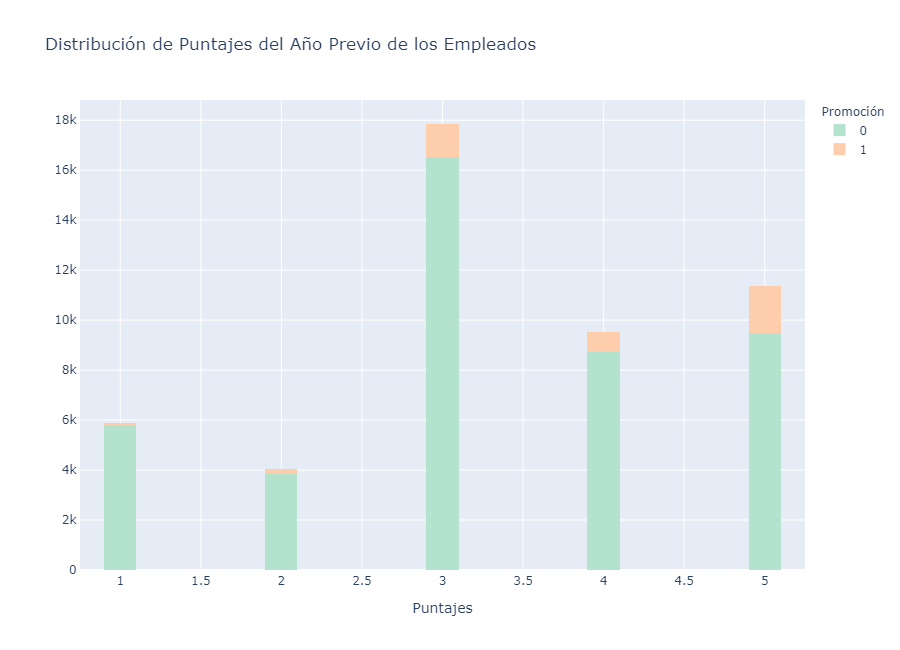

In [15]:
fig = px.histogram(df, x="previous_year_rating", title = "Distribución de Puntajes del Año Previo de los Empleados", color = "is_promoted", labels= {"previous_year_rating":"Puntajes","is_promoted": "Promoción"},nbins=35, color_discrete_sequence=px.colors.qualitative.Pastel2)
fig.update_layout(yaxis_title=" ")
fig.update_layout(
    autosize=False,
    width=900,
    height=650)
fig.update_xaxes( range=[0.75,5.25])
print("La media de rating previo de los empleados no promovidos es " + str(round(np.mean(df[df["is_promoted"]==0].previous_year_rating),2)))
print("La media de rating previo de los empleados promovidos es " + str(round(np.mean(df[df["is_promoted"]==1].previous_year_rating),2)))
hist = fig.to_image(format= "png")
Image(hist)

En esta variable podemos empezar a ver una diferencia entre los empleados promovidos y los no promovidos. Probablemente esta variable, como las otras basadas en el rendimiento sí sean buenos predictores para conocer quién será promovido.

### Años de Servicio

La media de años de servicio de los empleados no promovidos es 6.33
La media de años de servicio de los empleados promovidos es 6.12


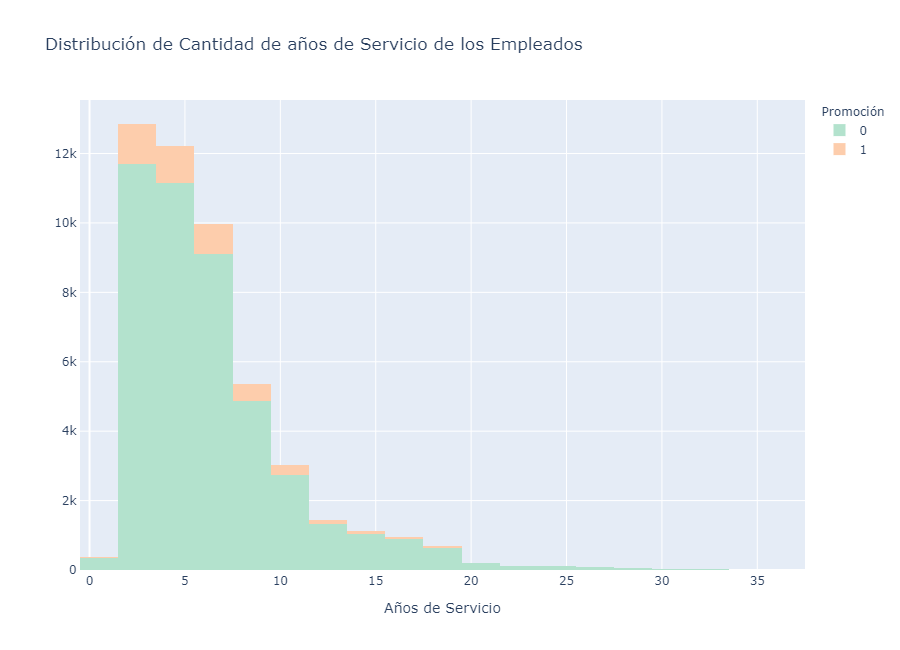

In [16]:
fig = px.histogram(df, x="length_of_service", title = "Distribución de Cantidad de años de Servicio de los Empleados", color = "is_promoted", labels= {"length_of_service":"Años de Servicio","is_promoted": "Promoción"},nbins=35, color_discrete_sequence=px.colors.qualitative.Pastel2)
fig.update_layout(yaxis_title=" ")
fig.update_layout(
    autosize=False,
    width=900,
    height=650)
print("La media de años de servicio de los empleados no promovidos es " + str(round(np.mean(df[df["is_promoted"]==0].length_of_service),2)))
print("La media de años de servicio de los empleados promovidos es " + str(round(np.mean(df[df["is_promoted"]==1].length_of_service),2)))
hist = fig.to_image(format= "png")
Image(hist)

### KPI > 80

El 4.08% de empleados que no superó el 80% de sus KPI fue promovido
El 17.02% de empleados que sí superó el 80% de sus KPI fue promovido


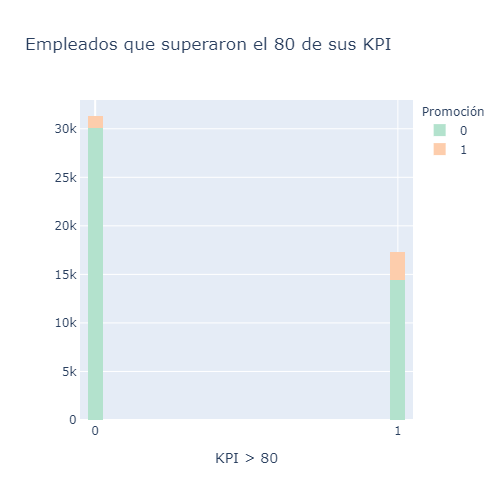

In [17]:
fig = px.histogram(df, x="KPIs_met >80%", title = "Empleados que superaron el 80 de sus KPI", color = "is_promoted", labels= {"KPIs_met >80%":"KPI > 80","is_promoted": "Promoción"},nbins=35, color_discrete_sequence=px.colors.qualitative.Pastel2)
fig.update_layout(yaxis_title=" ")
fig.update_layout(
    autosize=False,
    width=500,
    height=500)
fig.update_xaxes(range=[-0.05,1.05])
fig.update_xaxes(tickvals=[0, 1])

kpi_no = round(len(df[(df["is_promoted"]==1) & (df["KPIs_met >80%"] == 0)]) / len(df[df["KPIs_met >80%"] == 0]) *100, 2)
kpi_si = round(len(df[(df["is_promoted"]==1) & (df["KPIs_met >80%"] == 1)]) / len(df[df["KPIs_met >80%"] == 1]) *100, 2)

print("El " + str(kpi_no) + "% de empleados que no superó el 80% de sus KPI fue promovido")
print("El " + str(kpi_si) + "% de empleados que sí superó el 80% de sus KPI fue promovido")

hist = fig.to_image(format= "png")
Image(hist)

Como suponíamos, esta variable de rendimiento también se muestra como un criterio para la promoción de empleados.

### Premios

El 7.84% de empleados que no obtuvo premios fue promovido
El 44.76% de empleados que sí obtuvo permios fue promovido


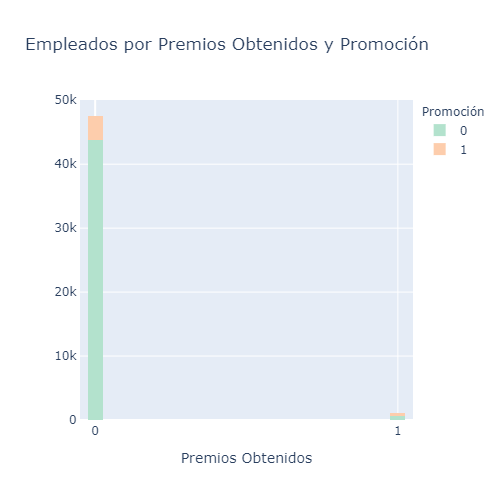

In [18]:
fig = px.histogram(df, x="awards_won?", title = "Empleados por Premios Obtenidos y Promoción", color = "is_promoted", labels= {"awards_won?":"Premios Obtenidos","is_promoted": "Promoción"},nbins=35, color_discrete_sequence=px.colors.qualitative.Pastel2)
fig.update_layout(yaxis_title=" ")
fig.update_layout(
    autosize=False,
    width=500,
    height=500)
fig.update_xaxes(range=[-0.05,1.05])
fig.update_xaxes(tickvals=[0, 1])

kpi_no = round(len(df[(df["is_promoted"]==1) & (df["awards_won?"] == 0)]) / len(df[df["awards_won?"] == 0]) *100, 2)
kpi_si = round(len(df[(df["is_promoted"]==1) & (df["awards_won?"] == 1)]) / len(df[df["awards_won?"] == 1]) * 100, 2)

print("El " + str(kpi_no) + "% de empleados que no obtuvo premios fue promovido")
print("El " + str(kpi_si) + "% de empleados que sí obtuvo permios fue promovido")

hist = fig.to_image(format= "png")
Image(hist)

### Puntajes de Evaluación

La media de puntajes obtenidos de empleados no promovidos es 62.87
La media de puntajes obtenidos de empleados promovidos es 71.32


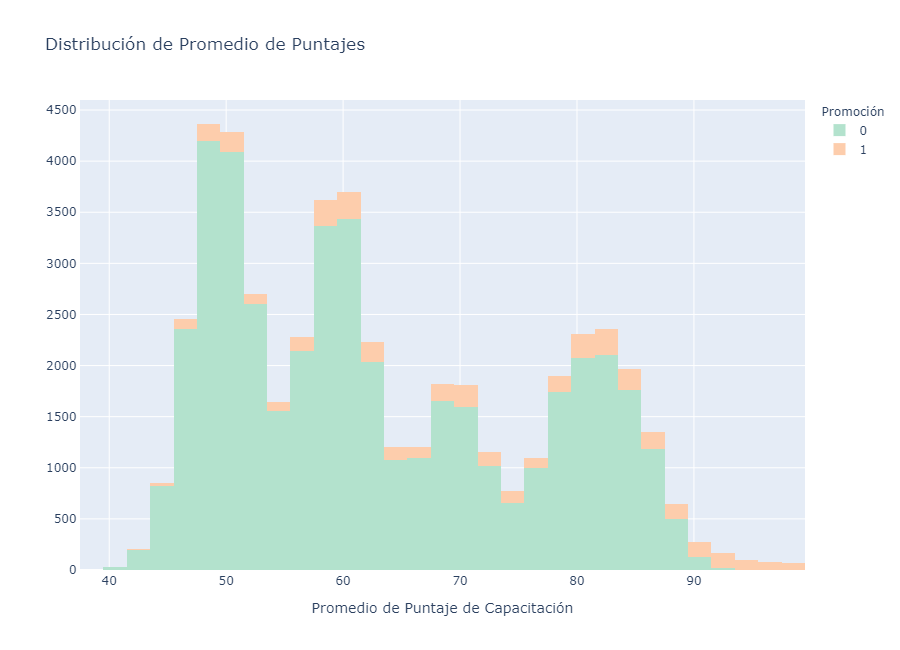

In [19]:
fig = px.histogram(df, x="avg_training_score", title = "Distribución de Promedio de Puntajes", color = "is_promoted", labels= {"avg_training_score":"Promedio de Puntaje de Capacitación","is_promoted": "Promoción"},nbins=35, color_discrete_sequence=px.colors.qualitative.Pastel2)
fig.update_layout(yaxis_title=" ")
fig.update_layout(
    autosize=False,
    width=900,
    height=650)
print("La media de puntajes obtenidos de empleados no promovidos es " + str(round(np.mean(df[df["is_promoted"]==0].avg_training_score),2)))
print("La media de puntajes obtenidos de empleados promovidos es " + str(round(np.mean(df[df["is_promoted"]==1].avg_training_score),2)))
hist = fig.to_image(format= "png")
Image(hist)

También observamos que esta variable tiene bastante peso para la promoción de empleados. Además de la diferencia en la media, podemos ver que son pocos empleados promovidos en los puntajes más bajos (alrededor del 50%) si lo ponemos en relación a la cantidad de empleados totales que obtuvieron ese puntaje promedio. Sin embargo, para los puntajes más altos (superiores al 90%), casi todos los empleados que obtienen estos puntajes son promovidos.

# Modelo de Predicción

### Limpieza de datos para entrenar el modelo

En primer lugar, vamos a eliminar la fila de ID de empleados porque no nos es útil para el modelo predictivo y las regiones por la gran cantidad que tenemos, lo que puede llevar a menor precisión

In [20]:
df.drop(["employee_id", "region"], axis=1, inplace=True)

Ahora necesitamos convertir las variables categóricas en numéricas, para esto vamos a convertir cada una de las categorías de estas variables en valores numerales como 0-1-2, etc. De acuerdo a la cantidad de categorías que tenga cada variable.

In [21]:
df.department = df.department.map({"Sales & Marketing":0,
                 "Operations":1,
                 "Technology":2,
                 "Analytics":3,
                 "R&D":4,
                 "Procurement":5,
                 "Finance":6,
                 "HR":7,
                 "Legal":8})
df.education = df.education.map({"Master's & above":0,
                                "Bachelor's":1,
                                "Below Secondary":2})
df.gender = df.gender.map({"f":0,
                          "m":1})
df.recruitment_channel = df.recruitment_channel.map({"sourcing":0,
                                                    "other":1,
                                                    "referred":2})
df.head()

,department,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,0,0,0,0,1,35,5,8,1,0,49,0
1,1,1,1,1,1,30,5,4,0,0,60,0
2,0,1,1,0,1,34,3,7,0,0,50,0
3,0,1,1,1,2,39,1,10,0,0,50,0
4,2,1,1,1,1,45,3,2,0,0,73,0


Ahora vamos a entrenar y comparar los puntajes de múltiples algoritmos de clasificación. Decidí ir por los más comunes, que son: Regresión Logística, Máquinas de Vector Soporte, Árboles de Decisión, Bosques Aleatorios de Clasificación, Clasificador Bayesiano Ingenuo y Potenciación Extrema de Gradiente (Extreme Gradient Boosting)

Como base, utilicé el [código de Roberto Salazar](https://towardsdatascience.com/machine-learning-classifiers-comparison-with-python-33149aecdbca) para esta tarea

In [22]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate, StratifiedKFold, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

features = df.drop("is_promoted",axis=1)
target = df.is_promoted

scoring = {'accuracy':make_scorer(accuracy_score), 
           'precision':make_scorer(precision_score),
           'recall':make_scorer(recall_score), 
           'f1_score':make_scorer(f1_score),
            'roc_auc':make_scorer(roc_auc_score)}

log_model = LogisticRegression(max_iter=10000)
svc_model = LinearSVC(dual=False)
dtr_model = DecisionTreeClassifier()
rfc_model = RandomForestClassifier()
gnb_model = GaussianNB()
xgb_model = xgb.XGBClassifier(objective= "binary:logistic")

def models_evaluation(X, y, folds):
    log = cross_validate(log_model, X, y, cv=folds, scoring=scoring)
    svc = cross_validate(svc_model, X, y, cv=folds, scoring=scoring)
    dtr = cross_validate(dtr_model, X, y, cv=folds, scoring=scoring)
    rfc = cross_validate(rfc_model, X, y, cv=folds, scoring=scoring)
    gnb = cross_validate(gnb_model, X, y, cv=folds, scoring=scoring)
    xgb = cross_validate(xgb_model, X, y, cv=folds, scoring=scoring)

    models_scores_table = pd.DataFrame({'Logistic Regression':[log['test_accuracy'].mean(),log['test_precision'].mean(),log['test_recall'].mean(),log['test_f1_score'].mean(),log['test_roc_auc'].mean()],'Support Vector Classifier':[svc['test_accuracy'].mean(),svc['test_precision'].mean(),svc['test_recall'].mean(),svc['test_f1_score'].mean(),svc['test_roc_auc'].mean()],'Decision Tree':[dtr['test_accuracy'].mean(),dtr['test_precision'].mean(),dtr['test_recall'].mean(),dtr['test_f1_score'].mean(),dtr['test_roc_auc'].mean()],'Random Forest':[rfc['test_accuracy'].mean(),rfc['test_precision'].mean(),rfc['test_recall'].mean(),rfc['test_f1_score'].mean(),rfc['test_roc_auc'].mean()],'Gaussian Naive Bayes':[gnb['test_accuracy'].mean(),gnb['test_precision'].mean(),gnb['test_recall'].mean(),gnb['test_f1_score'].mean(),gnb['test_roc_auc'].mean()],'Extreme Gradient Boosting':[xgb['test_accuracy'].mean(),xgb['test_precision'].mean(),xgb['test_recall'].mean(),xgb['test_f1_score'].mean(),xgb['test_roc_auc'].mean()]},index=['Accuracy', 'Precision', 'Recall', 'F1 Score', "AUC ROC"])

    models_scores_table['Best Score'] = models_scores_table.idxmax(axis=1)

    return(models_scores_table)
  
models_evaluation(features, target, 10)

,Logistic Regression,Support Vector Classifier,Decision Tree,Random Forest,Gaussian Naive Bayes,Extreme Gradient Boosting,Best Score
Accuracy,0.916543,0.915208,0.895191,0.932409,0.911323,0.938122,Extreme Gradient Boosting
Precision,0.669887,0.658141,0.407997,0.748598,0.465459,0.972590,Extreme Gradient Boosting
Recall,0.079160,0.051984,0.454163,0.335075,0.127830,0.297028,Decision Tree
F1 Score,0.141227,0.096007,0.429748,0.462685,0.200240,0.454355,Random Forest
AUC ROC,0.537734,0.524709,0.695682,0.662192,0.556892,0.648109,Decision Tree


Al interpretar estos resultados, debemos tener en cuenta lo siguiente:
1. El desbalance de nuestra variable objetivo: Como vimos al principio, la cantidad de empleados no promovidos es mayor al 90%. Esto significa que, si un modelo predictivo diera como 100% de toda la muestra como "no promovido", estaría acertando en el 90% de los casos. Por esta razón, el puntaje de "Accuracy" (Exactitud) de un modelo predictivo en esta situación no es el mejor a utilizar.
2. El problema que buscamos resolver: la principal demanda de la organización es la de detectar con anticipación aquellos empleados que pueden llegar a ser promovidos para poder prepararlos con mayor tiempo. Para saber exactamente a cual puntaje deberíamos priorizar, tendríamos que saber exactamente cómo tomará decisiones la empresa a partir de estos algoritmos, y cuál es el costo de cada tipo de error (error de tipo I y tipo II) para la empresa. Por ahora, tomaremos el algoritmo de Potenciación Extrema de Gradiente (XGBoost) porque aunque no es el que mejor se desempeña en todos los puntajes, se desempeña de manera equilibrada en todos ellos y tiene un muy alto puntajo de "Precisión".

### Ajuste de hiperparámetros

Debido a que este projecto es una simple demostración, no vamos a realizar una optimización de hiperparámetros a fuerza bruta porque llevaría mucho tiempo. Decidí realizar una optimización mediante una prueba aleatoria de hiperparámetros.

In [23]:
from datetime import datetime

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

        
params = {
        'min_child_weight': [1,3, 5, 7, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.2, 0.4, 0.6, 0.8, 1.0],
        'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1.0],
        'max_depth': [2, 3, 4, 5, 7,9]
        }

folds = 5
param_comb = 40

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 7)

random_search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=param_comb, scoring='f1',verbose = 3, n_jobs=4, cv=skf.split(features,target), random_state=7)


start_time = timer(None) 
random_search.fit(features, target)
timer(start_time)


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   14.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  1.8min finished



 Time taken: 0 hours 1 minutes and 51.61 seconds.


In [24]:
print('Parámetros Óptimos:')
print(random_search.best_params_)
print("\n Mejor Puntaje F1 Obtenido")
print(random_search.best_score_)

Parámetros Óptimos:
{'subsample': 1.0, 'min_child_weight': 10, 'max_depth': 9, 'gamma': 1, 'colsample_bytree': 1.0}

 Mejor Puntaje F1 Obtenido
0.5078619023528438


# Predicciones

Podemos ver que el modelo mejoró un 0.05 en el puntaje F1. Con este algoritmo de clasificación optimizado podemos realizar predicciones sobre nuevos datos y saber cuál empleado será promovido con anticipación, siempre teniendo en cuenta la falibilidad del modelo.

1. Al leer la nueva base de datos, debemos recordar que tenemos que hacer la misma limpieza de datos que hicimos para entrenar al algoritmo, es decir, eliminar las columnas de "ID" de los empleados y las regiones, además de imputar los mismos valores numéricos a las variables categóricas que utilizamos.

In [25]:
test = test_full.copy() 

test.drop(["employee_id","region"],axis=1, inplace=True)

test.department = test.department.map({"Sales & Marketing":0,
                 "Operations":1,
                 "Technology":2,
                 "Analytics":3,
                 "R&D":4,
                 "Procurement":5,
                 "Finance":6,
                 "HR":7,
                 "Legal":8})
test.education = test.education.map({"Master's & above":0,
                                "Bachelor's":1,
                                "Below Secondary":2})
test.gender = test.gender.map({"f":0,
                          "m":1})
test.recruitment_channel = test.recruitment_channel.map({"sourcing":0,
                                                    "other":1,
                                                    "referred":2})

test.head()

,department,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,2,1.0,1,0,1,24,NaN,1,1,0,77
1,7,1.0,0,1,1,31,3.0,5,0,0,51
2,0,1.0,1,1,1,31,1.0,4,0,0,47
3,5,1.0,0,1,3,31,2.0,9,0,0,65
4,6,1.0,1,0,1,30,4.0,7,0,0,61


El resultado final, es una base de datos que mostrará cuál empleado será promovido (1) y cuál no (0), y la probabilidad de que estos empleados tengan de ser promovidos de acuerdo a este modelo.

In [26]:
y_test = random_search.predict(test)
y_test_prob = random_search.predict_proba(test)
resultados = pd.DataFrame(data={'id':test_full['employee_id'], 'Promovido':y_test, "Probabilidad":y_test_prob[:,1]})
print(resultados.head())
print("La cantidad de Empleados Promovidos es de: " + str(len(resultados[resultados["Promovido"]==1])))

      id  Promovido  Probabilidad
0   8724          0      0.032952
1  74430          0      0.001081
2  72255          0      0.000406
3  38562          0      0.000485
4  64486          0      0.002705
La cantidad de Empleados Promovidos es de: 703
